In [ ]:
from google.colab import files
uploaded = files.upload()

Saving transactions.csv to transactions.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [ ]:
import pandas as pd

customers = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
transactions = pd.read_csv("transactions.csv")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [ ]:
# Convert date column
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

In [ ]:
# Handle TotalCharges column correctly
customers['TotalCharges'] = pd.to_numeric(
    customers['TotalCharges'], errors='coerce'
)

customers['TotalCharges'] = customers['TotalCharges'].fillna(
    customers['TotalCharges'].median()
)

# Encode target variable
customers['Churn'] = customers['Churn'].map({'Yes': 1, 'No': 0})



In [ ]:
purchase_frequency = (
    transactions.groupby('customerID')
    .size()
    .reset_index(name='purchase_frequency')
)

In [ ]:
avg_transaction_value = (
    transactions.groupby('customerID')['amount']
    .mean()
    .reset_index(name='avg_transaction_value')
)

In [ ]:
total_spend = (
    transactions.groupby('customerID')['amount']
    .sum()
    .reset_index(name='total_spend')
)

In [ ]:
customers = customers.merge(
    purchase_frequency, on='customerID', how='left'
)

customers = customers.merge(
    avg_transaction_value, on='customerID', how='left'
)

customers = customers.merge(
    total_spend, on='customerID', how='left'
)

In [ ]:
customers[['purchase_frequency',
           'avg_transaction_value',
           'total_spend']] = customers[
               ['purchase_frequency',
                'avg_transaction_value',
                'total_spend']
           ].fillna(0)

In [ ]:
customer_ids = customers['customerID']   # keep separately
customers = customers.drop('customerID', axis=1)

customers_encoded = pd.get_dummies(
    customers, drop_first=True
)

In [ ]:
num_cols = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges',
    'purchase_frequency',
    'avg_transaction_value',
    'total_spend'
]

scaler = StandardScaler()
customers_encoded[num_cols] = scaler.fit_transform(
    customers_encoded[num_cols]
)

In [ ]:
X = customers_encoded.drop('Churn', axis=1)
y = customers_encoded['Churn']

print("ETL & Feature Engineering Completed Successfully")
print("X shape:", X.shape)
print("y shape:", y.shape)

ETL & Feature Engineering Completed Successfully
X shape: (7043, 33)
y shape: (7043,)


In [ ]:
customers_encoded.to_csv("customers_final.csv", index=False)

# **PHASE 1: CHURN PREDICTION MODELS**

In [ ]:
import pandas as pd

data = pd.read_csv("customers_final.csv")

X = data.drop('Churn', axis=1)
y = data['Churn']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8041163946061036
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("Decision Tree Accuracy:", dt.score(X_test, y_test))
print("Random Forest Accuracy:", rf.score(X_test, y_test))


Decision Tree Accuracy: 0.7437899219304471
Random Forest Accuracy: 0.7984386089425124


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

print("Gradient Boosting Accuracy:", gb.score(X_test, y_test))


Gradient Boosting Accuracy: 0.7984386089425124


# **PHASE 2: UNSUPERVISED LEARNING (SEGMENTATION)**

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

data['Cluster'] = clusters
data[['Cluster']].value_counts()


,count
Cluster,
1,3251
0,2266
2,1526


In [ ]:
import matplotlib.pyplot as plt

transactions = pd.read_csv("transactions.csv")
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])


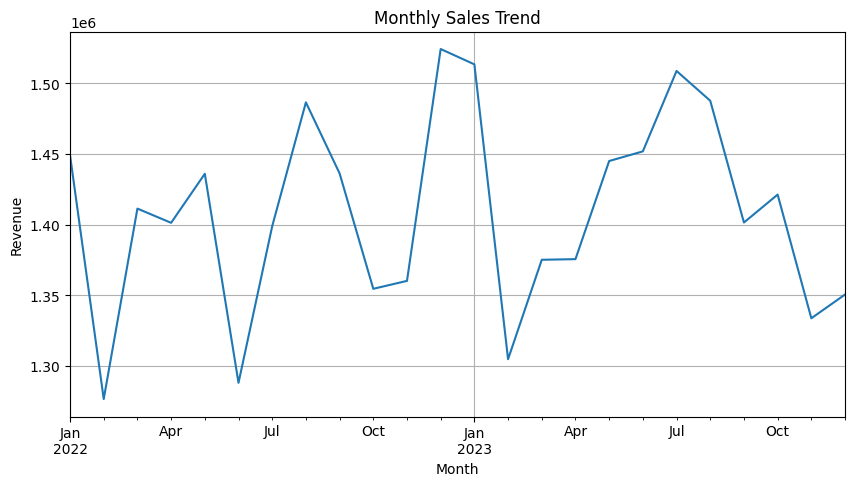

In [ ]:
transactions['month'] = transactions['transaction_date'].dt.to_period('M')

monthly_sales = transactions.groupby('month')['amount'].sum()

monthly_sales.plot(kind='line', figsize=(10,5))
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


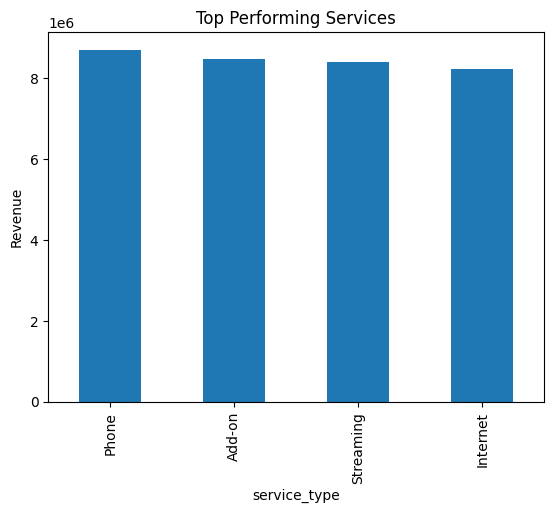

In [ ]:
top_services = (
    transactions.groupby('service_type')['amount']
    .sum()
    .sort_values(ascending=False)
)

top_services.plot(kind='bar', title="Top Performing Services")
plt.ylabel("Revenue")
plt.show()


In [ ]:
customers_raw = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

customers_raw['Churn'] = customers_raw['Churn'].map({'Yes': 1, 'No': 0})


In [ ]:
churn_revenue = transactions.merge(
    customers_raw[['customerID', 'Churn']],
    on='customerID',
    how='left'
)


In [ ]:
churn_revenue.groupby('Churn')['amount'].sum()


,amount
Churn,
0,24982835.87
1,8809953.53


In [ ]:
churn_revenue.groupby('Churn')['amount'].sum().rename({
    0: 'Non-Churned Customers',
    1: 'Churned Customers'
})


,amount
Churn,
Non-Churned Customers,24982835.87
Churned Customers,8809953.53


In [ ]:
from google.colab import files

files.download("customers_final.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load raw customer data
customers_raw = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Encode churn only (keep readable columns)
customers_raw['Churn'] = customers_raw['Churn'].map({'Yes': 1, 'No': 0})

# Merge transaction-based features
customers_dashboard = customers_raw.merge(
    purchase_frequency, on='customerID', how='left'
).merge(
    avg_transaction_value, on='customerID', how='left'
).merge(
    total_spend, on='customerID', how='left'
)

# Fill missing values
customers_dashboard[['purchase_frequency',
                     'avg_transaction_value',
                     'total_spend']] = customers_dashboard[
                         ['purchase_frequency',
                          'avg_transaction_value',
                          'total_spend']
                     ].fillna(0)

# Save dashboard dataset
customers_dashboard.to_csv("customers_dashboard.csv", index=False)


In [ ]:
from google.colab import files

files.download("customers_dashboard.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>